# Applications of Artificial Intelligence in Cyber Security

## Lab 7: PCA and MLP based Ransomeware Classification

# Dataset: Ransomware

Dataset Link: https://github.com/rissgrouphub/ransomwaredataset2016.git

## Download and Setup Dataset (Colab Users Only)

In [29]:
!rm -rf "/content/ransomwaredataset2016"
!git clone "https://github.com/rissgrouphub/ransomwaredataset2016.git"
!unzip "/content/ransomwaredataset2016/RansomwareData.zip" -d "/content/ransomwaredataset2016"

Cloning into 'ransomwaredataset2016'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 1.03 MiB | 2.96 MiB/s, done.
Archive:  /content/ransomwaredataset2016/RansomwareData.zip
  inflating: /content/ransomwaredataset2016/RansomwareData.csv  


## Imports and Load Dataset (For All Users)

In [30]:
# imports for data handling
# The os module allows to interact with the operating system for example reading and writing from directories
import os
# Powerful library for performing Different FUnctions on Arrays.
import numpy as np
# Pandas is used for data manipulation, analysis specially in tables of time series data.
import pandas as pd
# Seaborn is a python data visualization library based on matplotlib. it provides a high-level interface for drawing attractive and informative statistitcal graphics.
import seaborn as sns
# matplotlib is a comprehensive library plotting for creating static, animated, and interactive visualizatinos in Python.
import matplotlib.pyplot as plt
# This module implements specialized container datatypes providing alternatives to Python's general purpose built in containers, dict, list, set and tuple.
from collections import Counter

# imports for preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# imports for model evaluation
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


In [36]:
dataset_path = '/content/ransomwaredataset2016'
filename = 'RansomwareData.csv'
filepath = os.path.join(dataset_path, filename)


Read column names from file `VariableNames.txt`

In [37]:
variable_names = open(os.path.join(dataset_path, 'VariableNames.txt'),encoding='utf-8').readlines()
columns = []
for idx, variable_name in enumerate(variable_names):
    variable_name = variable_name.split(';')
    columns.append(variable_name[1].strip())
columns = np.array(columns)
columns[1] = 'Label'
print(columns.shape)


(30970,)


Read Ransomware Family Names (for Multiclass classification) from file `Family Names ID.txt`

In [38]:
family_names_file = open(os.path.join(dataset_path, 'Family Names ID.txt')).readlines()[2:]
family_names = {}
for idx, row in enumerate(family_names_file):
    row = row.strip()
    if len(row) <= 0: continue
    family_name, id = row[:-3].strip(), row[-3:].strip()
    if family_name != 'Goodware':
        family_name = family_name[1:-1]
    family_names[int(id)] = family_name
family_names


{0: 'Goodware',
 1: 'Critroni',
 2: 'CryptLocker',
 3: 'CryptoWall',
 4: 'KOLLAH',
 5: 'Kovter',
 6: 'Locker',
 7: 'MATSNU',
 8: 'PGPCODER',
 9: 'Reveton',
 10: 'TeslaCrypt',
 11: 'Trojan-Ransom'}

Load dataset as dataframe and apply some preprocessing

In [39]:
# read dataset
df = pd.read_csv(filepath, header=None)
df.columns = columns
# replace Null values with 0
df.fillna(0, inplace=True)
# shuffle rows for better train/val/test division
sampler = np.random.permutation(len(df))
df = df.take(sampler)
df = df.reset_index(drop=True)
# drop these columns due to their insignificance
df = df.drop(['ID'], axis=1)
columns = df.columns
# show dataframe
df


,Label,Ransomware Family,API:GetSystemDirectoryA,API:WriteConsoleA,API:NtOpenFile,API:NtCreateProcessEx,API:GetSystemInfo,API:WriteConsoleW,API:NtReadVirtualMemory,API:RemoveDirectoryA,...,STR:16258,STR:16259,STR:16260,STR:16261,STR:16262,STR:16263,STR:16264,STR:16265,STR:16266,STR:16267
0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,9,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1520,0,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1521,1,6,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1522,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Remove columns containing only one value

In [40]:
# df.apply function takes column one-by-one and return count of unique values
unique_vals_count_per_col = df.apply(lambda x: len(pd.unique(x)))
# Counter will count frequency of unique values, indicating number of columns with that unique value
print(Counter(unique_vals_count_per_col.values))
# those columns are relevant having more than one unique value
relevant_columns = unique_vals_count_per_col > 1
# select only relevant columns to remove irrelevant columns
df2 = df.iloc[:, relevant_columns.values]
columns = df.columns
# show dataframe
df2


Counter({np.int64(2): 23617, np.int64(1): 7351, np.int64(12): 1})


,Label,Ransomware Family,API:GetSystemDirectoryA,API:WriteConsoleA,API:NtOpenFile,API:NtCreateProcessEx,API:GetSystemInfo,API:WriteConsoleW,API:NtReadVirtualMemory,API:RemoveDirectoryA,...,STR:16247,STR:16252,STR:16253,STR:16255,STR:16256,STR:16259,STR:16260,STR:16261,STR:16264,STR:16267
0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,9,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1520,0,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1521,1,6,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1522,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
# separate dataframe into X and y
X = df2.drop(['Label', 'Ransomware Family'], axis=1)
y_binary = df2['Label']
y_multi = df2['Ransomware Family']


In [42]:
# check frequency of each binary class
class_labels_binary = df2['Label'].unique()
print(df2['Label'].value_counts())


Label
0    942
1    582
Name: count, dtype: int64


In [43]:
# check frequency of each multi class
class_labels_multi = df2['Ransomware Family'].unique()
print(df2['Ransomware Family'].value_counts())


Ransomware Family
0     942
2     107
6      97
9      90
5      64
7      59
1      50
3      46
11     34
4      25
10      6
8       4
Name: count, dtype: int64


## Evaluation Function

In [44]:
def get_one_vs_all(confusion_matrix, label):
    tp = confusion_matrix[label, label]
    fn = np.sum(confusion_matrix[label, :]) - tp
    fp = np.sum(confusion_matrix[:, label]) - tp
    tn = np.sum(confusion_matrix) - tp - fn - fp
    return tp, fn, fp, tn

def calculate_metrics(y_true, y_pred, y_prob, class_labels):
    labels = np.unique(y_true)
    columns = ['class_label', 'accuracy', 'recall', 'precision', 'f1_score', 'area_under_roc', 'area_under_pr']
    df_metrics = pd.DataFrame(index=range(len(labels)))
    cm = metrics.confusion_matrix(y_true, y_pred)

    for idx, label in enumerate(labels):
        y_true2 = y_true.copy()
        y_pred2 = y_pred.copy()
        y_prob2 = y_prob[:, label]
        # print('[condition]', np.where(y_true == label))
        y_true2[y_true == label] = 1
        y_true2[y_true != label] = 0
        y_pred2[y_pred == label] = 1
        y_pred2[y_pred != label] = 0
        tp, fn, fp, tn = get_one_vs_all(cm, idx)
        # print(tp, fn, fp, tn)
        accuracy = (tp + tn) / (tp + tn + fn + fp)
        epsilon = 1e-7 # is used so that to avoid divide by zero error
        recall = tp / (tp + fn + epsilon)
        precision = tp / (tp + fp + epsilon)
        f1_score = 2 * recall * precision / (recall + precision)
        area_under_roc = metrics.roc_auc_score(y_true2, y_prob2)

        precisions, recalls, _ = metrics.precision_recall_curve(y_true2, y_prob2)
        area_under_pr = metrics.auc(recalls, precisions)

        # print('[label]', label)
        df_metrics.loc[label, 'class_label'] = class_labels[label]
        df_metrics.loc[label, 'accuracy'] = accuracy
        df_metrics.loc[label, 'precision'] = precision
        df_metrics.loc[label, 'recall'] = recall
        df_metrics.loc[label, 'f1_score'] = f1_score
        df_metrics.loc[label, 'area_under_roc'] = area_under_roc
        df_metrics.loc[label, 'area_under_pr'] = area_under_pr

    if len(labels) == 2:
        df_metrics = df_metrics.drop(index=0)

    print(df_metrics)
    # df_metrics['class_label'] = df_metrics['class_label'].astype(int)

    return df_metrics


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC

def plot_roc_curve_multi(y_true, y_prob, class_labels, suptitle):
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle(suptitle)

    labels = np.unique(y_true)
    roc_curves = {}

    # plot roc curves in one-vs-all manner, meaning one curve per class
    for label in labels:
        y_true2 = y_true.copy()
        y_true2[y_true == label] = 1
        y_true2[y_true != label] = 0
        y_prob2 = y_prob[:, label]
        FP_rate, TP_rate, _ = metrics.roc_curve(y_true2, y_prob2)
        roc_auc = metrics.roc_auc_score(y_true2, y_prob2)
        plt.plot(FP_rate, TP_rate, label=f'{class_labels[label]} (roc_auc = {roc_auc:.4f})')

    plt.xlabel('FP Rate')
    plt.ylabel('TP Rate')
    plt.legend(fontsize=8)


## Binary Class

### Preprocessing

In [46]:
y = y_binary
class_labels = sorted(class_labels_binary)
class_names = ['Goodware', 'Malware']
print(class_labels)


[np.int64(0), np.int64(1)]


In [47]:
# Dividing data into training, testing and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=103, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=103, stratify=y_train)
print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(1524, 23616) (1524,)
(975, 23616) (975,)
(244, 23616) (244,)
(305, 23616) (305,)


### PCA Visialization

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X_train)
print('PCA fit completed')
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

PCA fit completed


Draw Scree Plot to show the importance of principle components

<BarContainer object of 10 artists>

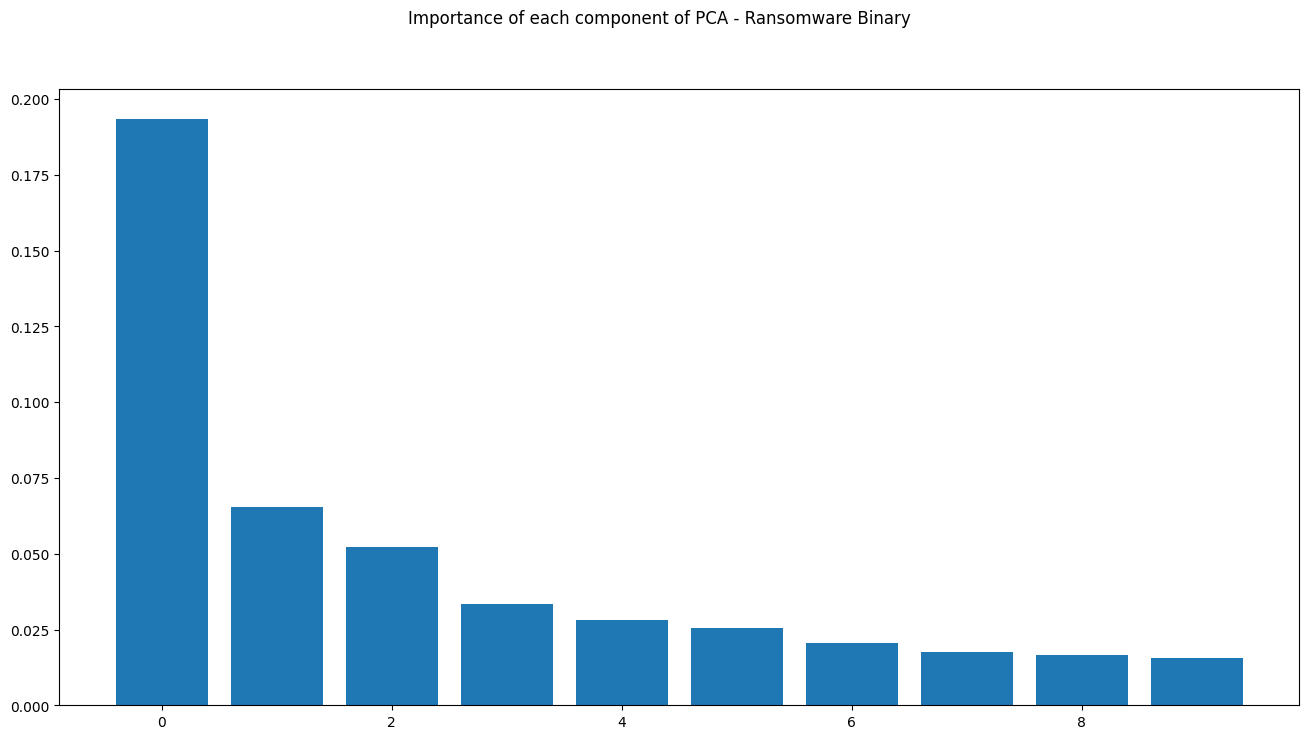

In [49]:
plt.figure(figsize=(16, 8))
plt.suptitle('Importance of each component of PCA - Ransomware Binary')
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

X.shape: (1524, 23616) ; X_train_pca.shape: (975, 10)


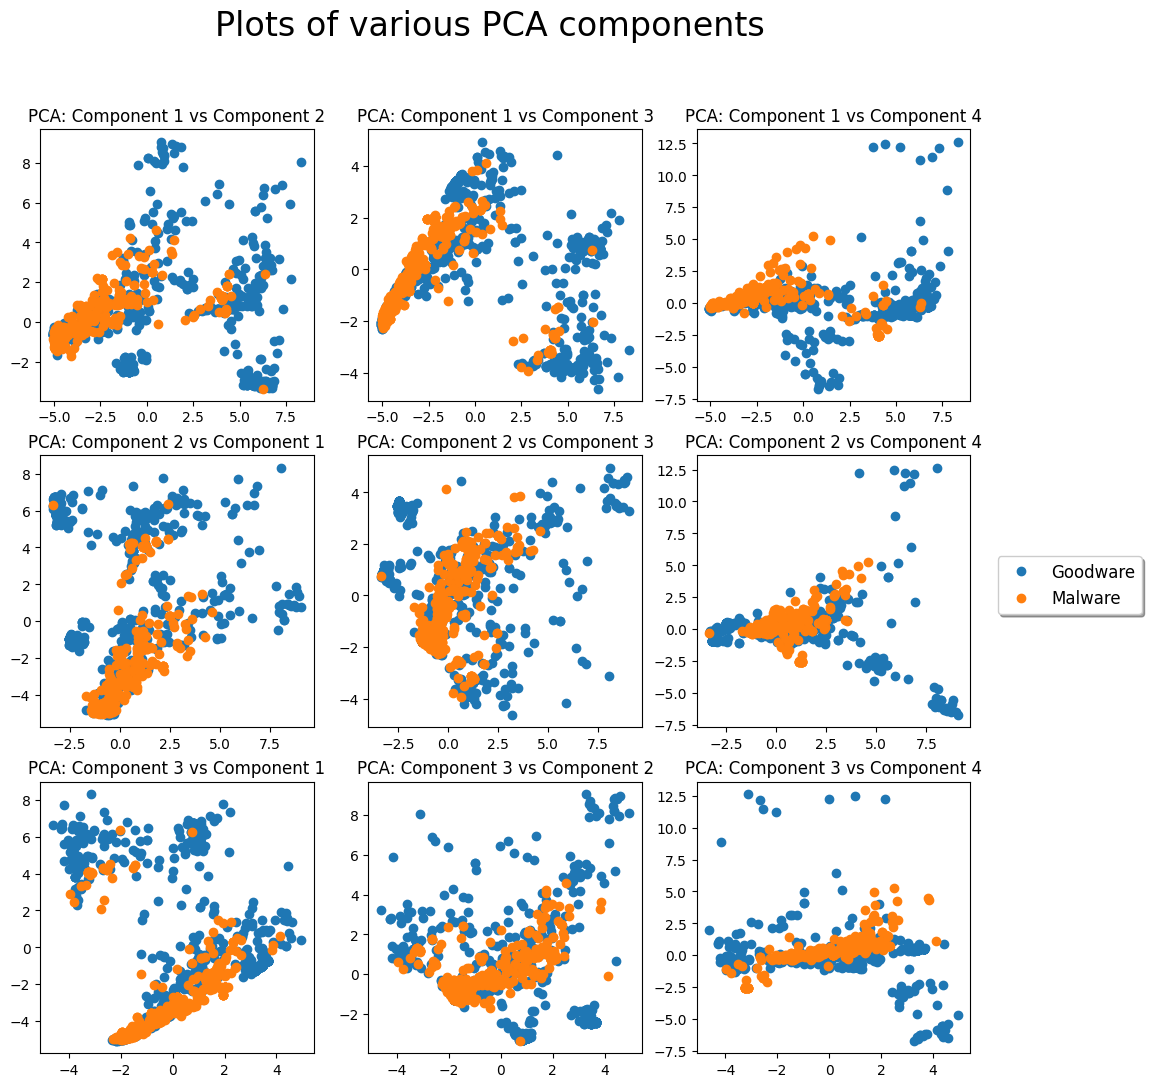

In [50]:
X_train_pca = pca.transform(X_train)
print('X.shape:', X.shape, '; X_train_pca.shape:', X_train_pca.shape)
fig, axes = plt.subplots(3, 3)
fig.set_size_inches(12, 12)
fig.suptitle('Plots of various PCA components', fontsize=24)

for class_idx in class_labels:
    indices = (y_train == class_idx)
    i2 = 0
    for i in range(3):
        j2 = 0
        for j in range(4):
            if i == j: continue
            x_coords = X_train_pca[indices, i]
            y_coords = X_train_pca[indices, j]
            label = class_names[class_idx]
            axes[i2, j2].plot(x_coords, y_coords, 'o', label=label)
            subplot_title = f'PCA: Component {i + 1} vs Component {j + 1}'
            axes[i2, j2].set_title(subplot_title)
            j2 += 1
        i2 += 1

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='center right', fancybox=True, shadow=True, fontsize=12, bbox_to_anchor=(1.05, 0.5))


### MLP without PCA

In [51]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 128, 128, len(class_names)), max_iter=10, random_state=105, verbose=True)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)
mlp_metrics_binary = calculate_metrics(y_test, y_pred, y_prob, class_names)
mlp_metrics_binary['label-type'] = 'binary'
mlp_metrics_binary['model'] = 'MLP-without-PCA'
mlp_metrics_binary

Iteration 1, loss = 0.55595868
Iteration 2, loss = 0.35912991
Iteration 3, loss = 0.30701983
Iteration 4, loss = 0.27541465
Iteration 5, loss = 0.25462389
Iteration 6, loss = 0.24131738
Iteration 7, loss = 0.23438732
Iteration 8, loss = 0.22594344
Iteration 9, loss = 0.22226605
Iteration 10, loss = 0.21931494


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


  class_label  accuracy  precision    recall  f1_score  area_under_roc  \
1     Malware  0.957377   0.918699  0.974138  0.945607        0.974913   

   area_under_pr  
1       0.960198  


,class_label,accuracy,precision,recall,f1_score,area_under_roc,area_under_pr,label-type,model
1,Malware,0.957377,0.918699,0.974138,0.945607,0.974913,0.960198,binary,MLP-without-PCA


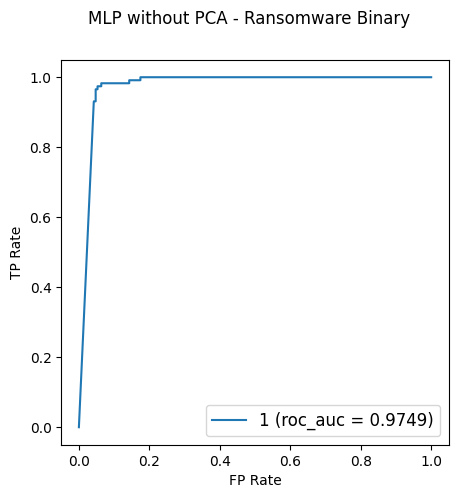

In [52]:
y_prob = mlp.predict_proba(X_test)
plot_roc_curve_binary(y_test, y_prob, suptitle='MLP without PCA - Ransomware Binary')

Accuracy: 0.9574
Recall: 0.9187
Precision: 0.9741
F1-Score: 0.9456
Area Under ROC Curve: 0.9606
Area Under PR Curve: 0.9513
Precison, Recall, F1-Score:
               precision    recall  f1-score   support

           0     0.9835    0.9471    0.9650       189
           1     0.9187    0.9741    0.9456       116

    accuracy                         0.9574       305
   macro avg     0.9511    0.9606    0.9553       305
weighted avg     0.9589    0.9574    0.9576       305



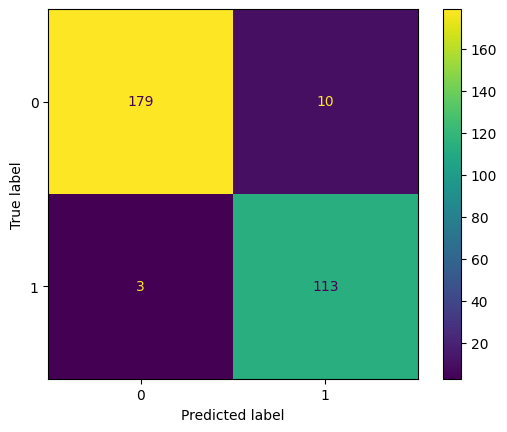

In [53]:
print_metrices(y_test, y_pred)

### MLP with PCA

In [54]:
n_components = 100
pca = PCA(n_components=n_components)
pca.fit(X_train)
print(f'Variance explained by first {n_components} components:', sum(pca.explained_variance_ratio_))

# transform train dataset using PCA
X_train_pca = pca.transform(X_train)
print('X_train.shape:', X_train.shape, '; X_train_pca.shape:', X_train_pca.shape)
# transform val dataset using PCA
X_val_pca = pca.transform(X_val)
print('X_val.shape:', X_val.shape, '; X_val_pca.shape:', X_val_pca.shape)
# transform test dataset using PCA
X_test_pca = pca.transform(X_test)
print('X_test.shape:', X_test.shape, '; X_test_pca.shape:', X_test_pca.shape)


Variance explained by first 100 components: 0.831108024098997
X_train.shape: (975, 23616) ; X_train_pca.shape: (975, 100)
X_val.shape: (244, 23616) ; X_val_pca.shape: (244, 100)
X_test.shape: (305, 23616) ; X_test_pca.shape: (305, 100)


In [55]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 128, 128, len(class_names)), max_iter=25, random_state=105, verbose=True)
mlp.fit(X_train_pca, y_train)
y_pred = mlp.predict(X_test_pca)
y_prob = mlp.predict_proba(X_test_pca)
mlp_pca_metrics_binary = calculate_metrics(y_test, y_pred, y_prob, class_names)
mlp_pca_metrics_binary['label-type'] = 'binary'
mlp_pca_metrics_binary['model'] = 'MLP-with-PCA'
mlp_pca_metrics_binary

Iteration 1, loss = 0.75467077
Iteration 2, loss = 0.60165606
Iteration 3, loss = 0.47106544
Iteration 4, loss = 0.36983331
Iteration 5, loss = 0.31180813
Iteration 6, loss = 0.27782886
Iteration 7, loss = 0.25809482
Iteration 8, loss = 0.24281646
Iteration 9, loss = 0.23164999
Iteration 10, loss = 0.22535372
Iteration 11, loss = 0.21818882
Iteration 12, loss = 0.21183447
Iteration 13, loss = 0.21022697
Iteration 14, loss = 0.20518425
Iteration 15, loss = 0.20165723
Iteration 16, loss = 0.19975471
Iteration 17, loss = 0.19833725
Iteration 18, loss = 0.19358644
Iteration 19, loss = 0.19361811
Iteration 20, loss = 0.18932873
Iteration 21, loss = 0.18686531
Iteration 22, loss = 0.18473458
Iteration 23, loss = 0.18315445
Iteration 24, loss = 0.18090022
Iteration 25, loss = 0.18074906
  class_label  accuracy  precision    recall  f1_score  area_under_roc  \
1     Malware   0.97377   0.965517  0.965517  0.965517        0.998768   

   area_under_pr  
1       0.998073  


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


,class_label,accuracy,precision,recall,f1_score,area_under_roc,area_under_pr,label-type,model
1,Malware,0.97377,0.965517,0.965517,0.965517,0.998768,0.998073,binary,MLP-with-PCA


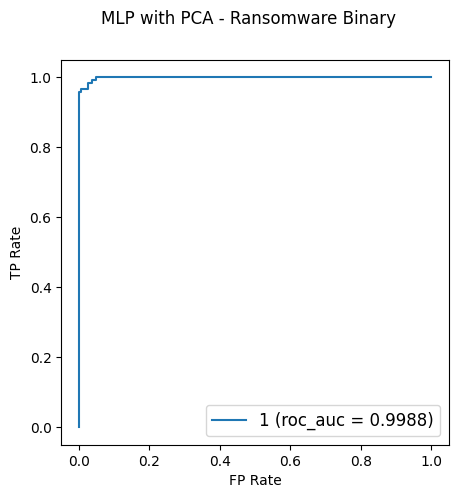

In [56]:
y_prob = mlp.predict_proba(X_test_pca)
plot_roc_curve_binary(y_test, y_prob, suptitle='MLP with PCA - Ransomware Binary')

Accuracy: 0.9738
Recall: 0.9655
Precision: 0.9655
F1-Score: 0.9655
Area Under ROC Curve: 0.9722
Area Under PR Curve: 0.9721
Precison, Recall, F1-Score:
               precision    recall  f1-score   support

           0     0.9788    0.9788    0.9788       189
           1     0.9655    0.9655    0.9655       116

    accuracy                         0.9738       305
   macro avg     0.9722    0.9722    0.9722       305
weighted avg     0.9738    0.9738    0.9738       305



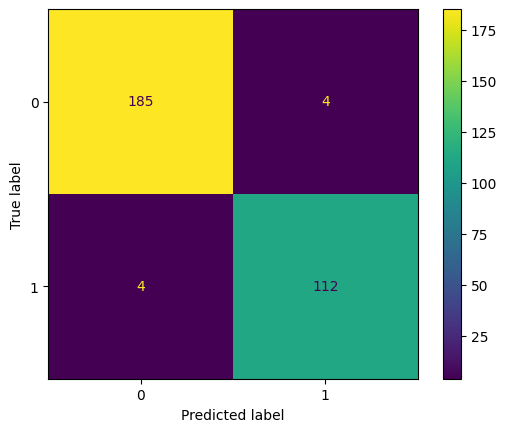

In [57]:
print_metrices(y_test, y_pred)

In [58]:
pd.concat([mlp_metrics_binary, mlp_pca_metrics_binary], axis=0)

,class_label,accuracy,precision,recall,f1_score,area_under_roc,area_under_pr,label-type,model
1,Malware,0.957377,0.918699,0.974138,0.945607,0.974913,0.960198,binary,MLP-without-PCA
1,Malware,0.973770,0.965517,0.965517,0.965517,0.998768,0.998073,binary,MLP-with-PCA


##  Multi Class

### Preprocessing

In [59]:
y = y_multi
class_labels = sorted(class_labels_multi)
class_names = list(family_names.values())
print(class_labels)
print(class_names)

[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]
['Goodware', 'Critroni', 'CryptLocker', 'CryptoWall', 'KOLLAH', 'Kovter', 'Locker', 'MATSNU', 'PGPCODER', 'Reveton', 'TeslaCrypt', 'Trojan-Ransom']


In [60]:
# Dividing data into training, testing and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=103, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=103, stratify=y_train)

print(X.shape, y.shape)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(1524, 23616) (1524,)
(975, 23616) (975,)
(244, 23616) (244,)
(305, 23616) (305,)


### PCA Visialization

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X_train)
print('PCA fit completed')
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)

PCA fit completed


Draw Scree Plot to show the importance of principle components

<BarContainer object of 10 artists>

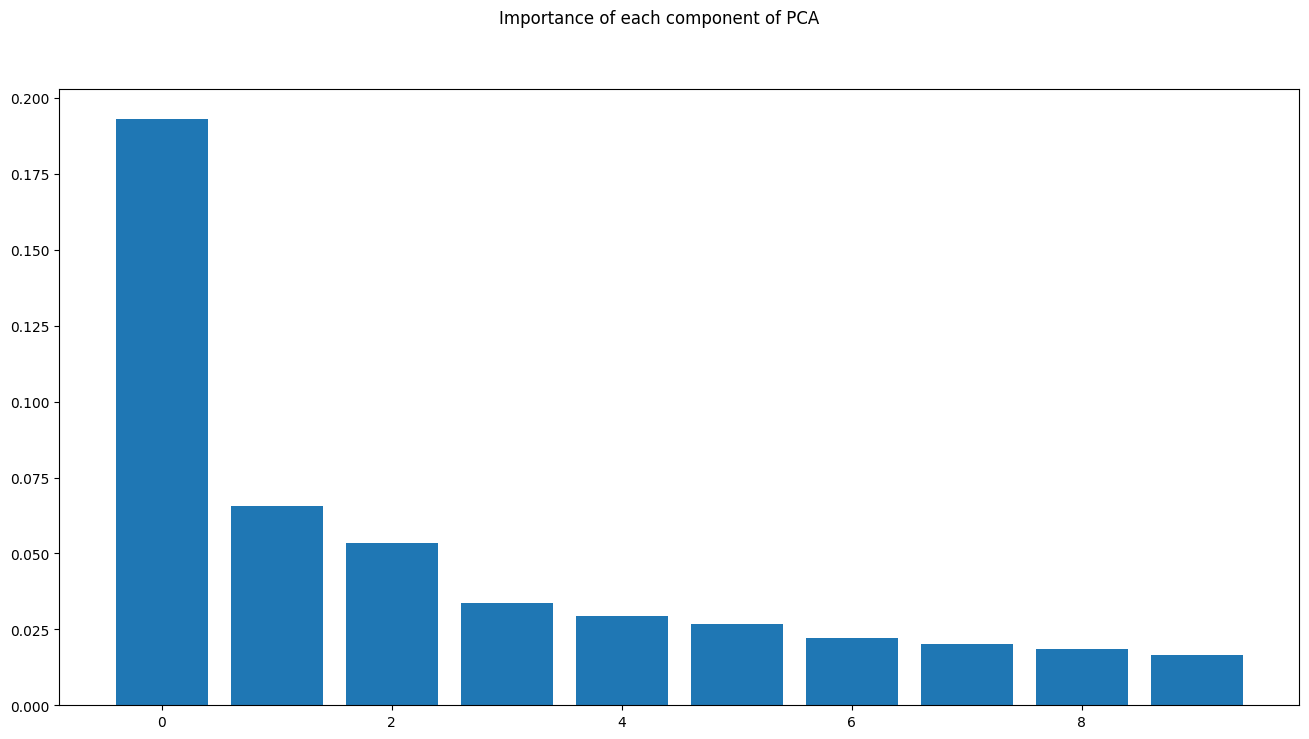

In [62]:
plt.figure(figsize=(16, 8))
plt.suptitle('Importance of each component of PCA')
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

X.shape: (1524, 23616) ; X_train_pca.shape: (975, 10)


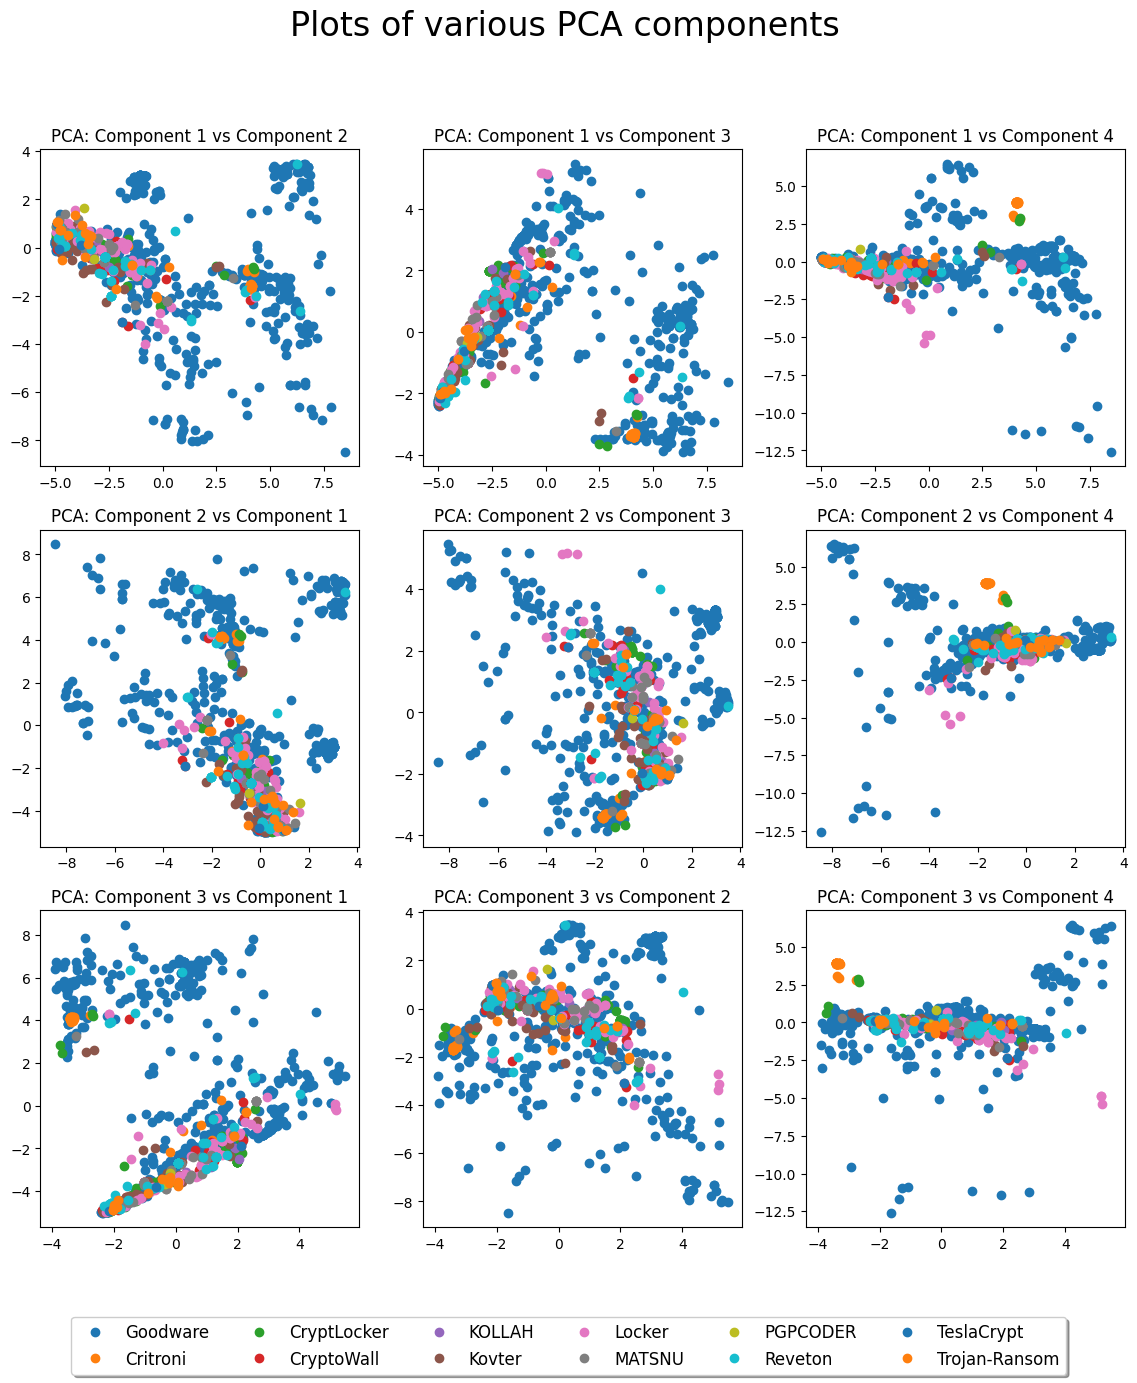

In [63]:
X_train_pca = pca.transform(X_train)
print('X.shape:', X.shape, '; X_train_pca.shape:', X_train_pca.shape)
fig, axes = plt.subplots(3, 3)
fig.set_size_inches(14, 14)
fig.suptitle('Plots of various PCA components', fontsize=24)

for class_idx in class_labels:
    indices = (y_train == class_idx)
    i2 = 0
    for i in range(3):
        j2 = 0
        for j in range(4):
            if i == j: continue
            x_coords = X_train_pca[indices, i]
            y_coords = X_train_pca[indices, j]
            class_name = class_names[class_idx]
            axes[i2, j2].plot(x_coords, y_coords, 'o', label=class_name)
            subplot_title = f'PCA: Component {i + 1} vs Component {j + 1}'
            axes[i2, j2].set_title(subplot_title)
            j2 += 1
        i2 += 1

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='lower center', ncol=6, fancybox=True, shadow=True, fontsize=12)


### MLP without PCA

In [64]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 128, 128, len(class_names)), max_iter=10, random_state=105, verbose=True)
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)
mlp_metrics_multi = calculate_metrics(y_test, y_pred, y_prob, class_names)
mlp_metrics_multi['label-type'] = 'multi'
mlp_metrics_multi['model'] = 'MLP-without-PCA'
mlp_metrics_multi = mlp_metrics_multi.sort_values(by='class_label', ignore_index=True)
mlp_metrics_multi

Iteration 1, loss = 2.17059050
Iteration 2, loss = 1.69974669
Iteration 3, loss = 1.41304461
Iteration 4, loss = 1.26138837
Iteration 5, loss = 1.14290256
Iteration 6, loss = 1.06003420
Iteration 7, loss = 0.98984316
Iteration 8, loss = 0.92696202
Iteration 9, loss = 0.86761071
Iteration 10, loss = 0.80460652


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


      class_label  accuracy  precision    recall  f1_score  area_under_roc  \
0        Goodware  0.927869   0.928205  0.957672  0.942708        0.975278   
1        Critroni  0.977049   0.800000  0.400000  0.533333        0.881017   
2     CryptLocker  0.931148   0.000000  0.000000       NaN        0.923625   
3      CryptoWall  0.967213   0.333333  0.111111  0.166667        0.764640   
4          KOLLAH  0.983607   0.000000  0.000000       NaN        0.876000   
5          Kovter  0.980328   1.000000  0.538462  0.700000        0.979189   
6          Locker  0.855738   0.234043  0.578947  0.333333        0.880751   
7          MATSNU  0.898361   0.243243  0.750000  0.367347        0.942833   
8        PGPCODER  0.996721   0.000000  0.000000       NaN        0.582237   
9         Reveton  0.977049   1.000000  0.611111  0.758621        0.936895   
10     TeslaCrypt  0.996721   0.000000  0.000000       NaN        0.855263   
11  Trojan-Ransom  0.977049   0.000000  0.000000       NaN      

/tmp/ipython-input-1746777523.py:29: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * recall * precision / (recall + precision)
/tmp/ipython-input-1746777523.py:29: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * recall * precision / (recall + precision)
/tmp/ipython-input-1746777523.py:29: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * recall * precision / (recall + precision)
/tmp/ipython-input-1746777523.py:29: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * recall * precision / (recall + precision)
/tmp/ipython-input-1746777523.py:29: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * recall * precision / (recall + precision)


,class_label,accuracy,precision,recall,f1_score,area_under_roc,area_under_pr,label-type,model
0,Critroni,0.977049,0.800000,0.400000,0.533333,0.881017,0.554608,multi,MLP-without-PCA
1,CryptLocker,0.931148,0.000000,0.000000,NaN,0.923625,0.659681,multi,MLP-without-PCA
2,CryptoWall,0.967213,0.333333,0.111111,0.166667,0.764640,0.092914,multi,MLP-without-PCA
3,Goodware,0.927869,0.928205,0.957672,0.942708,0.975278,0.987745,multi,MLP-without-PCA
4,KOLLAH,0.983607,0.000000,0.000000,NaN,0.876000,0.111421,multi,MLP-without-PCA
5,Kovter,0.980328,1.000000,0.538462,0.700000,0.979189,0.845571,multi,MLP-without-PCA
6,Locker,0.855738,0.234043,0.578947,0.333333,0.880751,0.231372,multi,MLP-without-PCA
7,MATSNU,0.898361,0.243243,0.750000,0.367347,0.942833,0.648091,multi,MLP-without-PCA
8,PGPCODER,0.996721,0.000000,0.000000,NaN,0.582237,0.003906,multi,MLP-without-PCA
9,Reveton,0.977049,1.000000,0.611111,0.758621,0.936895,0.733699,multi,MLP-without-PCA


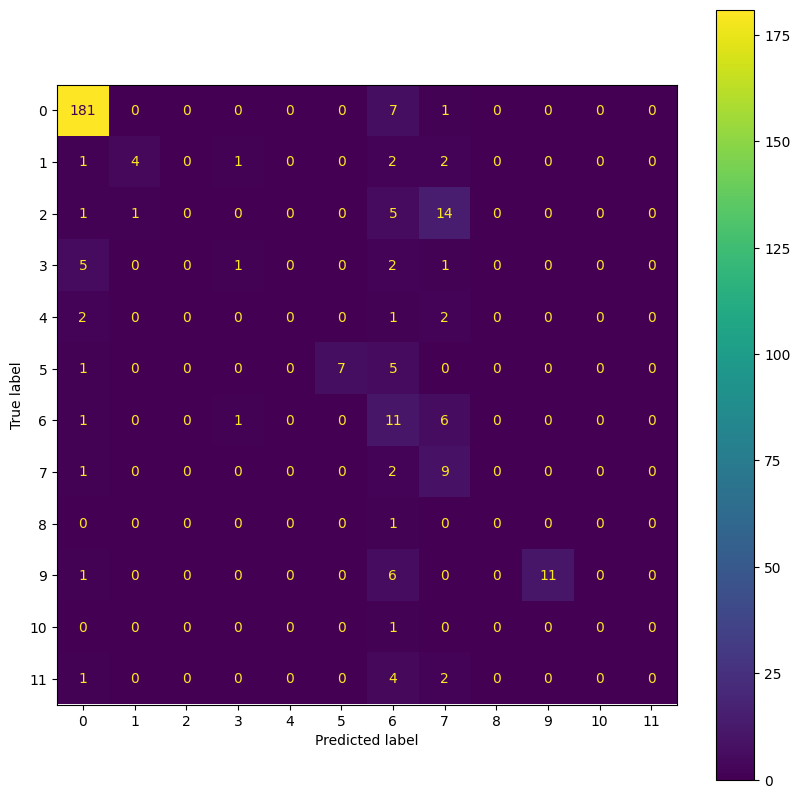

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)

### MLP with PCA

In [66]:
n_components = 100
pca = PCA(n_components=n_components)
pca.fit(X_train)
print(f'Variance explained by first {n_components} components:', sum(pca.explained_variance_ratio_))

# transform train dataset using PCA
X_train_pca = pca.transform(X_train)
print('X_train.shape:', X_train.shape, '; X_train_pca.shape:', X_train_pca.shape)
# transform val dataset using PCA
X_val_pca = pca.transform(X_val)
print('X_val.shape:', X_val.shape, '; X_val_pca.shape:', X_val_pca.shape)
# transform test dataset using PCA
X_test_pca = pca.transform(X_test)
print('X_test.shape:', X_test.shape, '; X_test_pca.shape:', X_test_pca.shape)


Variance explained by first 100 components: 0.8280353449207902
X_train.shape: (975, 23616) ; X_train_pca.shape: (975, 100)
X_val.shape: (244, 23616) ; X_val_pca.shape: (244, 100)
X_test.shape: (305, 23616) ; X_test_pca.shape: (305, 100)


In [67]:
mlp = MLPClassifier(hidden_layer_sizes=(128, 128, 128, len(class_names)), max_iter=10, random_state=105, verbose=True)
mlp.fit(X_train_pca, y_train)
y_pred = mlp.predict(X_test_pca)
y_prob = mlp.predict_proba(X_test_pca)
mlp_pca_metrics_multi = calculate_metrics(y_test, y_pred, y_prob, labels)
mlp_pca_metrics_multi['label-type'] = 'multi'
mlp_pca_metrics_multi['model'] = 'MLP-with-PCA'
mlp_pca_metrics_multi = mlp_pca_metrics_multi.sort_values(by='class_label', ignore_index=True)
mlp_pca_metrics_multi

Iteration 1, loss = 2.06801335
Iteration 2, loss = 1.56161703
Iteration 3, loss = 1.36949080
Iteration 4, loss = 1.21298008
Iteration 5, loss = 1.10893406
Iteration 6, loss = 1.02745684
Iteration 7, loss = 0.96163116
Iteration 8, loss = 0.90313170
Iteration 9, loss = 0.85057421
Iteration 10, loss = 0.80292293
      class_label  accuracy  precision    recall  f1_score  area_under_roc  \
0        Goodware  0.914754   0.879070  1.000000  0.935644        0.989236   
1        Critroni  0.977049   0.800000  0.400000  0.533333        0.915932   
2     CryptLocker  0.937705   0.583333  0.333333  0.424242        0.918008   
3      CryptoWall  0.970492   0.000000  0.000000       NaN        0.824324   
4          KOLLAH  0.983607   0.000000  0.000000       NaN        0.856667   
5          Kovter  0.957377   0.000000  0.000000       NaN        0.924658   
6          Locker  0.839344   0.241379  0.736842  0.363636        0.891240   
7          MATSNU  0.967213   1.000000  0.166667  0.285714       

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/tmp/ipython-input-1746777523.py:29: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * recall * precision / (recall + precision)
/tmp/ipython-input-1746777523.py:29: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * recall * precision / (recall + precision)
/tmp/ipython-input-1746777523.py:29: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * recall * precision / (recall + precision)
/tmp/ipython-input-1746777523.py:29: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * recall * precision / (recall + precision)
/tmp/ipython-input-1746777523.py:29: RuntimeWarning: invalid value encountered in scalar divide
  f1_score = 2 * recall * precision / (recall + precisio

,class_label,accuracy,precision,recall,f1_score,area_under_roc,area_under_pr,label-type,model
0,Critroni,0.977049,0.800000,0.400000,0.533333,0.915932,0.594209,multi,MLP-with-PCA
1,CryptLocker,0.937705,0.583333,0.333333,0.424242,0.918008,0.559686,multi,MLP-with-PCA
2,CryptoWall,0.970492,0.000000,0.000000,NaN,0.824324,0.097148,multi,MLP-with-PCA
3,Goodware,0.914754,0.879070,1.000000,0.935644,0.989236,0.993223,multi,MLP-with-PCA
4,KOLLAH,0.983607,0.000000,0.000000,NaN,0.856667,0.099390,multi,MLP-with-PCA
5,Kovter,0.957377,0.000000,0.000000,NaN,0.924658,0.411012,multi,MLP-with-PCA
6,Locker,0.839344,0.241379,0.736842,0.363636,0.891240,0.283672,multi,MLP-with-PCA
7,MATSNU,0.967213,1.000000,0.166667,0.285714,0.941695,0.564554,multi,MLP-with-PCA
8,PGPCODER,0.996721,0.000000,0.000000,NaN,0.911184,0.017857,multi,MLP-with-PCA
9,Reveton,0.970492,0.846154,0.611111,0.709677,0.933217,0.778252,multi,MLP-with-PCA


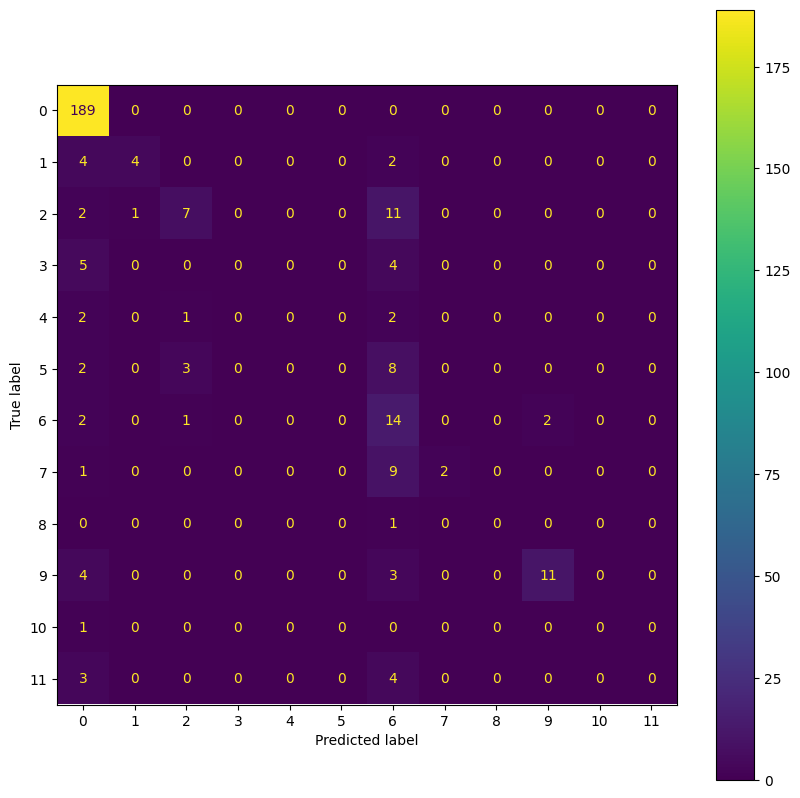

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)

In [69]:
pd.concat([mlp_metrics_multi, mlp_pca_metrics_multi], axis=0)

,class_label,accuracy,precision,recall,f1_score,area_under_roc,area_under_pr,label-type,model
0,Critroni,0.977049,0.800000,0.400000,0.533333,0.881017,0.554608,multi,MLP-without-PCA
1,CryptLocker,0.931148,0.000000,0.000000,NaN,0.923625,0.659681,multi,MLP-without-PCA
2,CryptoWall,0.967213,0.333333,0.111111,0.166667,0.764640,0.092914,multi,MLP-without-PCA
3,Goodware,0.927869,0.928205,0.957672,0.942708,0.975278,0.987745,multi,MLP-without-PCA
4,KOLLAH,0.983607,0.000000,0.000000,NaN,0.876000,0.111421,multi,MLP-without-PCA
5,Kovter,0.980328,1.000000,0.538462,0.700000,0.979189,0.845571,multi,MLP-without-PCA
6,Locker,0.855738,0.234043,0.578947,0.333333,0.880751,0.231372,multi,MLP-without-PCA
7,MATSNU,0.898361,0.243243,0.750000,0.367347,0.942833,0.648091,multi,MLP-without-PCA
8,PGPCODER,0.996721,0.000000,0.000000,NaN,0.582237,0.003906,multi,MLP-without-PCA
9,Reveton,0.977049,1.000000,0.611111,0.758621,0.936895,0.733699,multi,MLP-without-PCA


---